In [11]:
!curl -L "https://docs.google.com/uc?export=download&id=1CgR9w26BU4nli_ecg-3Ukgc06NNOD3BD" > csce5300-prediction-competition.zip
!unzip csce5300-prediction-competition.zip -d ./

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    889      0 --:--:-- --:--:-- --:--:--   889
100  129k  100  129k    0     0   180k      0 --:--:-- --:--:-- --:--:--  180k
Archive:  csce5300-prediction-competition.zip
replace ./sample_prediction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./sample_prediction.csv  
  inflating: ./test_luc.csv          
  inflating: ./train_luc.csv         
  inflating: ./tutorial_code.ipynb   


In [12]:
#%%

# This is a tutorial to create a simple prediction model to perform the following
# 1. Read in and show basic information about the training data
# 2. Create a simple prediction model on a portion of the training data
# 3. Test the quality of the model on a later portion of the data
# 4. Create a final model using all the training data based on the best choices above
# 5. Apply that model to the test data, to be scored on the kaggle.com site

# FILES NEEDED: for this code to work, you will need train_luc.csv and test_luc.csv
# in the same folder as this notebook

In [13]:
import pandas as pd
import numpy as np
import csv as csv
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
# read the data and display the first 5 rows
train_df = pd.read_csv('train_luc.csv', header=0)

print("\nNumber of samples:",train_df.shape[0],"and number of features:",train_df.shape[1],"\n")

train_df.head()


Number of samples: 9174 and number of features: 12 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Understanding basic stats of the data set

In [15]:
# read about the data elsewhere, however, it is critical to observe the data to make sure
# everything is read in correctly and matches the description

train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000,9174.000000
mean,2.505559,0.031284,0.678875,1.414868,20.130401,23.578433,61.715064,12.737931,35.713647,154.868106,190.581753
std,1.116618,0.174094,0.466934,0.635363,7.940504,8.617957,19.401829,8.199027,49.667738,150.981155,181.011530
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,46.000000,7.001500,4.000000,35.000000,41.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,61.000000,11.001400,16.000000,117.000000,144.000000
75%,4.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,48.000000,222.000000,282.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,886.000000,977.000000


# Create a new feature

In [16]:
# let's take datetime (which isn't very useful to algorithms) and turn it into something useful.
# e.g. this will create a new column for the hour
def hour_of_day(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour
train_df['hour'] = train_df['datetime'].map(hour_of_day)
train_df.head()
# note the new column on the right labelled "hour"

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


# Make visualizations to better understand your data

hours: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Measured bike use over 2 years')

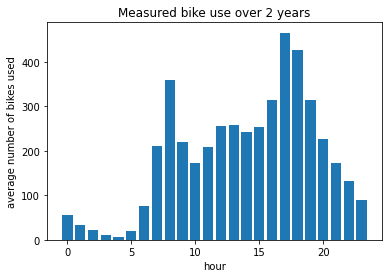

In [17]:
# now let's take a look at the amerage amount of bike use for each hour of the day
# as a "sanity check" to make sure the data makes sense before going further
hours = np.unique(train_df['hour'])
print("hours:",hours)

hours_mean = {}
for h in hours:
    temp_df = train_df.loc[train_df['hour'] == h]
    hours_mean[h] = temp_df['count'].mean()

# plot the results. Maybe should see peaks from bike commuting or evening use
plt.bar(hours,[hours_mean[h] for h in hours])
plt.xlabel("hour")
plt.ylabel("average number of bikes used")
plt.title("Measured bike use over 2 years")

# Pick the features and the model


In [18]:
# pick your features
# cols = ['hour'] # clearly a simple model
# try more features later, like...
# cols = ['hour','season']
required_cols = ["hour"]
cols = ['season', "holiday", "workingday", "weather", "atemp", "temp", "humidity", "windspeed"]
#cols = ['hour', 'season', 'workingday', 'weather', 'atemp']

# pick your model (you should consider adjusting optional parameters too)
# reading in a few models we can pick from (there are many others)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

# pick one by commenting/uncommenting
model1 = DecisionTreeRegressor()
model2 = LinearRegression()
model3 = KNeighborsRegressor(n_neighbors = 5)
model4 = LinearSVR(max_iter=10000)
model5 = RandomForestRegressor(n_estimators = 1)

model_list = [model1, model2, model3, model4, model5]

print("columns selected for later:",cols)
print(model4) # to get an idea of parameters and confirm model chosen

columns selected for later: ['season', 'holiday', 'workingday', 'weather', 'atemp', 'temp', 'humidity', 'windspeed']
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
          random_state=None, tol=0.0001, verbose=0)


In [20]:
from sklearn.model_selection import train_test_split

random_forest_cols = ['hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity']

train_vals = train_df[random_forest_cols]
train_results = train_df['count']

train_vals_cnn = train_vals.to_numpy()
train_results_cnn = train_results.to_numpy()

#train_vals_cnn = train_vals_cnn.reshape(train_vals_cnn.shape[0], 
#                                        train_vals_cnn.shape[1], 1)

xtrain, xtest, ytrain, ytest=train_test_split(train_vals_cnn, train_results_cnn, 
                                                test_size=.3, random_state=42)

for n in range(1, 1):
    rf_model = RandomForestRegressor(n_estimators = n)

    rf_model.fit(xtrain, ytrain)

    ypred = rf_model.predict(xtest)

    # score the model on the new test set
    rms = np.sqrt(mean_squared_error(ytest, ypred))

    print(n, ":",rms)



In [21]:
import itertools

all_combinations = []
for r in range(len(cols) + 1):
    combinations_object = itertools.combinations(cols, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

# for combo in all_combinations:
#     print(list(combo))

#Test 1
#all_combinations = [cols]
# all_combinations = [['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity'],
#                     ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
#                     ]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

for combo in all_combinations:
    combo = list(combo)
    if len(combo) >= 2: 
        random_forest_cols = required_cols + combo
        print("Starting with columns:", random_forest_cols)
        train_vals = train_df[random_forest_cols]
        train_results = train_df['count']

        train_vals_rf = train_vals.to_numpy()
        train_results_rf = train_results.to_numpy()


        xtrain, xtest, ytrain, ytest=train_test_split(train_vals_cnn, train_results_cnn, 
                                                test_size=.1, random_state=42)
        # Number of trees in random forest
        n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 5, 10]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2, 4]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]

        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

        # Use the random grid to search for best hyperparameters
        # First create the base model to tune
        rf = RandomForestRegressor(random_state = 42)
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                                    n_iter = 100, scoring='neg_root_mean_squared_error', 
                                    cv = 10, verbose=0, random_state=42, n_jobs=3,
                                    return_train_score=True)

        # Fit the random search model
        rf_random.fit(xtrain, ytrain)
        # rf_model = RandomForestRegressor(n_estimators = 10)
        #   predict on the testing subset of the original training data
        ypred = rf_random.predict(xtest)

        # score the model on the new test set
        rms = np.sqrt(mean_squared_error(ytest, ypred))
        # rf_model.fit(train_vals_cnn, train_results_cnn)
        print(rms, "For params:", rf_random.best_params_)

Starting with columns: ['hour', 'season', 'holiday']


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [27]:
import sklearn 
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


# Separate your training and test sets

In [ ]:
# this is a way of splitting training and testing by hand
# however, there are tools to do this automatically
# google "cross validation" for a better/more advanced strategy
#--------------------

n = len(train_df) # get number of rows in the training set
training_size = 0.75 # fraction of training data to split off for internal testing

# set up separate training and testing sets
# in this case using shuffled array indices
# there are many more ways to do this too
indices = np.array(range(n)) # makes an array of row indices in order
from numpy.random import shuffle
shuffle(indices)
split_point = int(n*training_size)
mytrain_i = indices[0:split_point]
mytest_i = indices[split_point:]

# now use those shuffled indices to separating training from test dataframes
new_train_df = train_df.iloc[mytrain_i]
new_test_df = train_df.iloc[mytest_i]

print("samples in the new training subset:",len(new_train_df))
print("samples in the new test subset:",len(new_test_df))

samples in the new training subset: 6880
samples in the new test subset: 2294


# Fit the model to a portion of the training set, test on the rest and evaluate


In [ ]:
print(cols)

['season', 'holiday', 'workingday', 'weather', 'atemp', 'temp', 'humidity', 'windspeed']


In [ ]:
from sklearn.datasets import load_boston
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPool1D, BatchNormalization, LeakyReLU,  ReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import losses, regularizers

def sequential_nn(input_dims):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(32, 2, activation="relu", input_shape=input_dims))
    cnn_model.add(Dense(64, activation="relu"))
    cnn_model.add(Dropout(0.3))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPool1D())
    cnn_model.add(Flatten())
    cnn_model.add(Dense(32, activation="relu"))
    cnn_model.add(Dense(15, activation="relu"))
    cnn_model.add(Dense(1))

    return cnn_model


In [ ]:
def rmse_loss(ytest, ypred):
    return np.sqrt(mean_squared_error(ytest, ypred))

In [34]:
best_model_cols = ""
best_score = 99999
best_model = None

NUM_EPOCHS = 50000
BATCH_SIZE = 256
TRAIN_TEST_SIZE = 0.15

for combo in all_combinations:
    combo = list(combo)
    if len(combo) >= 2: 
        for loss_var in range(1,3):
            loss_type = 'mae'
            if loss_var % 2 ==0:
                loss_type = 'mse'
            combo = required_cols + combo
            
            train_vals = train_df[combo]
            train_results = train_df['count']

            train_vals_cnn = train_vals.to_numpy()
            train_results_cnn = train_results.to_numpy()

            train_vals_cnn = train_vals_cnn.reshape(train_vals_cnn.shape[0], 
                                                    train_vals_cnn.shape[1], 1)

            xtrain, xtest, ytrain, ytest=train_test_split(train_vals_cnn, train_results_cnn, 
                                                            test_size=TRAIN_TEST_SIZE, random_state=42)
            
            cnn_model = sequential_nn(input_dims=(len(combo), 1))

            cnn_model.compile(loss=loss_type, optimizer="adam", metrics=['mae', 'mse'])

            # print("Started Training", list(combo))
            # try on whole model?
            # cnn_model.fit(train_vals_cnn, train_results_cnn, batch_size=64, epochs=1000, verbose=0)

            cnn_model.fit(xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=0)

            # predict on the testing subset of the original training data
            ypred = cnn_model.predict(xtest)

            # score the model on the new test set
            rms = np.sqrt(mean_squared_error(ytest, ypred))
            if rms < best_score:
                best_score = rms
                best_model_cols = combo
                best_model = cnn_model
            print(rms, list(combo), "with loss type", loss_type)

print("Best cols: ", best_model_cols)
print("With RMSE: ", best_score)

82.35057898555314 ['hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity'] with loss type mae
83.64125802333912 ['hour', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity'] with loss type mse
81.90216047214496 ['hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed'] with loss type mae
72.13525380807054 ['hour', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed'] with loss type mse
Best cols:  ['hour', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
With RMSE:  72.13525380807054


In [35]:
print("Best cols: ", best_model_cols)
print("With RMSE: ", best_score)

Best cols:  ['hour', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed']
With RMSE:  72.13525380807054


In [36]:
best_model.save("best_model")
#print(ytest)

INFO:tensorflow:Assets written to: best_model/assets


In [37]:
!zip best_model best_model/

  adding: best_model/ (stored 0%)


In [38]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error

def rmse(y_actual, y_predicted, **kwargs):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
for model in model_list:
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    scores = cross_val_score(model, new_train_df[cols], new_train_df['count'], scoring=rmse_scorer, cv=folds)
    print(scores)

[-199.18508106 -197.48528981 -194.72540067 -195.94159701 -197.24219334]
[-154.98707785 -155.99872065 -150.64972953 -159.08460825 -152.5441461 ]
[-160.84234653 -161.09023941 -156.90967156 -163.95868214 -160.02447732]
[-158.65941902 -160.90133469 -154.47777158 -163.72152314 -157.40522715]
[-200.73793049 -212.4159268  -193.63891877 -201.44112526 -202.96828467]


In [39]:
# fit the model to the training subset of original training data
best_model = None
best_rmse = None
for model in model_list:
    #model.fit(new_train_df[cols], new_train_df['count'])

    # predict on the testing subset of the original training data
    pred_count = model.predict(new_test_df[cols])

    # score the model on the new test set
    rms = np.sqrt(mean_squared_error(new_test_df['count'],pred_count))
    print("RMS error:",rms)
    if best_model is None or rms < best_rmse:
        best_model = model
        best_rmse = rms

NotFittedError: ignored

In [ ]:
print("Best rmse: ", best_rmse)

# Creating the test file output


In [ ]:
# read in the test data
test_df = pd.read_csv('test_luc.csv', header=0)
print("\nNumber of samples:",test_df.shape[0] ,"and number of features:",test_df.shape[1],"\n")

# must add that new feature into the test data too, to use it in prediction
test_df['hour'] = test_df['datetime'].map(hour_of_day)

# show the test data output to be sure it read in correctly and added the column
test_df.head()

# fit the selected model TO YOUR FULL TRAINING SET
#history = best_model.fit( train_df[cols], train_df['count'])

# apply to the test data FOR WHICH YOU DON'T HAVE THE ANSWERS
# (not the "test set" you used for model selection and tuning)
final_cols = ['hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'humidity']
test_cnn = test_df[final_cols].to_numpy()
test_cnn = test_cnn.reshape(test_cnn.shape[0], test_cnn.shape[1], 1)
pred_count = best_model.predict(test_cnn)

# add the prediction column (in case you want to inspect it later)
test_df['count'] = pred_count

# save the predicted count as a csv with a header column and datetime row
test_df = test_df[['datetime','count']].to_csv('my_prediction.csv', 
    index=False, header=True)
print("Prediction complete. Saved as my_prediction.csv")

In [ ]:
# Scratch


# Current RMS error of: 73.44168707407283 
# Last RMS error: 79
# print("RMS error of:", rms, "\n")
# Best cols:  ['season', 'holiday', 'workingday', 'temp', 'windspeed']
# With RMSE:  67.09231422002402


# cnn_model = Sequential()
# cnn_model.add(Dense(6,activation = tf.keras.activations.relu, input_shape=(6,1), 
#                        kernel_regularizer=regularizers.l2(0.01), 
#                        activity_regularizer=regularizers.l1(0.01)))
# cnn_model.add(Dense(3, activation="relu"))
# cnn_model.add(Dropout(0.1, noise_shape=None))
# cnn_model.add(Dense(1))
# cnn_model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mse'])

# def rms_loss(y_actual, y_predicted):
#     with tf.name_scope('rms_loss'):
#         return np.sqrt(mean_squared_error(y_actual, y_predicted))


# cnn_model = Sequential()
# cnn_model.add(Conv1D(32, 2, input_shape=(6, 1)))
# cnn_model.add(Dense(64, activation="relu"))
# cnn_model.add(BatchNormalization())
# cnn_model.add(MaxPool1D())
# cnn_model.add(Flatten())
# cnn_model.add(Dense(32, activation="relu"))
# cnn_model.add(Dropout(0.1))
# cnn_model.add(Dense(1))


    # model = Sequential()
    # model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(6, 1)))
    # model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(MaxPool1D(pool_size=2))
    # model.add(Flatten())
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(1, activation='softmax'))
  # Input dimensions: (None, 3, 3, 512)
#   model.add(Flatten())
#   model.add(Dense(512,activation='relu'))
#   model.add(Dropout(0.1))
#   model.add(Dense(1))
  